In [1]:
api_key = "INSIRA SUA API KEY DA BINANCE AQUI"
secret_key = "INSIRA SUA SECRETY KEY DA BINANCE AQUI"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from binance.client import Client
from functools import reduce
from sklearn.cluster import KMeans
import talib
import yfinance  as yf
import plotly.graph_objects as go

In [3]:
client = Client(api_key=api_key, api_secret = secret_key, tld = "com")

In [4]:
#Obtendo todos os pares USDT disponíveis
prices = pd.DataFrame(client.get_all_tickers())
prices = prices[prices.symbol.str.contains("USDT")]
symbolcoins = prices['symbol'].tolist()


In [5]:
listadf = []
adj_lista = []
adj_volatility = []
for symbol in symbolcoins:
    ###Esse Loop interage com API para retornar dados históricos (200 dias)
     ## de todos os pares USDT disponíveis na Binance e retorna dois dataframes

    klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY, "200 day ago UTC")
  
    timestamp = client._get_earliest_valid_timestamp(symbol = symbol, interval = "1d")
    pd.to_datetime(timestamp, unit = "ms")
    df = pd.DataFrame(klines)
    #Filtrando inconsistências
    if len(df.columns) > 13 or len(df.columns) < 5:
          continue
    
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close",
                  "Volume", "Clos Time", "Quote Asset Volume", "Number of Trade",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    data = df[["Date", "Close", "Volume"]].set_index("Date")
    for column in data.columns: data[column] = pd.to_numeric(data[column], errors = "coerce")
    
    data['Volume'] = data['Volume'] *  data['Close'] #Volume em USD
     
    data[f"vol_ch_{symbol}"] = np.log(data.Volume.div(data.Volume.shift(1))) #Calculando diferença de Volume d-1
    data["price_ch"] = (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1) #Calculando diferença de preço d-1
    adj_volatility.append(str(symbol))
    adj_volatility.append(data["price_ch"].std()*200**.5) #Calculando desvio padrão 200 períodos
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')
    adj_volatility.append((data['Volume'].ewm(span=7, adjust=False).mean())[-1])
    #Calculado volume medio, atribuindo maior peso aos valores mais recentes
    adj_volatility.append(data['price_ch'].iloc[-1])
    data.rename(columns={'Close': f'Close_{symbol}', 'Volume': f'Volume_{symbol}',
                         'price_ch' : f'price_ch_{symbol}'}, inplace= True)
    
    adj_lista.append(adj_volatility)
    listadf.append(data)
    df = []
    adj_volatility = []

In [6]:
df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
prices_changes = df.filter(regex='price_ch_')
prices_changes = prices_changes*100
prices_changes

/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df=  reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), listadf)
/tmp/ipykernel_14051/3459067979.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

,price_ch_BTCUSDT,price_ch_ETHUSDT,price_ch_BNBUSDT,price_ch_NEOUSDT,price_ch_LTCUSDT,price_ch_QTUMUSDT,price_ch_ADAUSDT,price_ch_XRPUSDT,price_ch_EOSUSDT,price_ch_TUSDUSDT,...,price_ch_GASUSDT,price_ch_GLMUSDT,price_ch_PROMUSDT,price_ch_QKCUSDT,price_ch_UFTUSDT,price_ch_IDUSDT,price_ch_ARBUSDT,price_ch_LOOMUSDT,price_ch_OAXUSDT,price_ch_RDNTUSDT
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-19,0.622368,3.107508,2.141247,1.699029,0.532016,2.137351,1.116819,7.606264,1.883830,-0.020000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-20,-3.388541,-3.855434,-2.059581,-0.477327,-1.152901,-1.612350,-2.319417,7.588358,3.158706,0.010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-21,-2.191470,-5.831752,-0.863688,-3.597122,-2.313576,-4.044630,-0.746269,-4.927536,-11.799851,0.010001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-22,5.093178,6.476264,4.280303,4.975124,4.854179,5.632267,4.442925,23.526423,4.826418,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-01,-0.044370,-0.040076,-0.631114,-1.189532,3.349336,0.901191,-1.754826,-5.191664,-0.250836,0.000000,...,1.131626,1.784973,0.206186,4.634897,-0.663228,1.455379,-6.951141,-0.121065,-7.157287,-2.941176
2023-04-02,-0.987111,-1.443330,-0.381073,-2.808989,0.216053,-1.212121,-2.653738,1.668302,3.017603,-0.050005,...,-2.414605,-2.773246,-2.880658,-3.689840,-2.373887,-4.054832,-7.076019,-1.878788,-9.263289,-6.839033
2023-04-03,-1.320005,0.891608,-1.562002,-1.073493,0.215587,0.387472,1.494102,-4.266409,-4.393816,0.020012,...,-0.995775,-2.097315,-2.542373,-1.591708,-0.937183,-4.718860,-4.044607,-1.389747,3.117506,-3.789913


In [40]:
#Filtrando alterações de volume e volatilidade ajustada pela mediana
adjdf= pd.DataFrame(adj_lista, columns=['symbol', 'adj', 'Volume', 'price_ch'])
adj = adjdf[(adjdf['Volume'] > adjdf['Volume'].median()) & (adjdf['adj'] > adjdf['adj'].median())]
adj


,symbol,adj,Volume,price_ch
15,ICXUSDT,0.753703,4.526353e+07,0.000258
20,WAVESUSDT,0.737129,4.342463e+06,-0.000941
24,ZRXUSDT,0.745363,2.012138e+07,-0.025579
25,FETUSDT,1.142491,1.537536e+07,-0.003050
30,CELRUSDT,0.788540,4.117469e+06,-0.006002
...,...,...,...,...
372,LQTYUSDT,1.229125,2.744313e+07,-0.018087
381,IDUSDT,1.312253,5.227817e+07,-0.002932
382,ARBUSDT,0.901483,2.709179e+08,0.011422
384,OAXUSDT,1.163885,9.417585e+06,0.007373


## Volatilidade Ajustada Vs Volume - Pares USDT

In [41]:
z = np.random.rand(100)
data = [go.Scatter(x=adj['Volume'], y=adj['adj'], text=adj['symbol'], mode='markers',  
                   marker=dict( color=z, colorscale='Viridis'))]

layout = go.Layout(title='Volatilidade Ajustada vs Volume',
                   xaxis=dict(title='Volume 7D'),
                   yaxis=dict(title='Volatilidade Ajustada (Método Desvio Padrão 200 períodos)'))

fig = go.Figure(data=data, layout=layout)
fig.show()


/home/erivelton/anaconda3/envs/binance_python/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/tmp/ipykernel_14051/4131987072.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



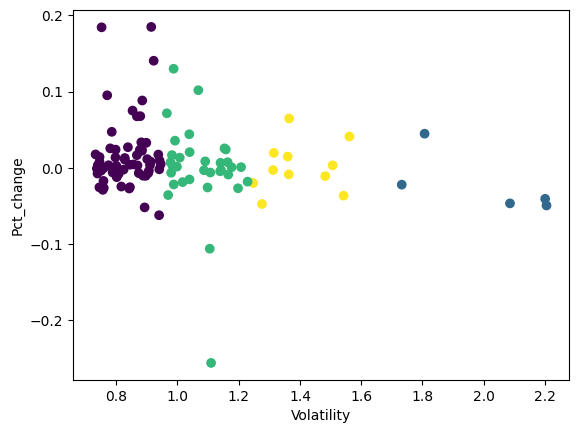

In [42]:
#Para facilitar a visualizacao dos ativos, criou-se um modelo de clusterizacao com base na volatilidade e alteracao de preco (d-1)

# Selecionando as colunas de interesse
X = adj[["adj", "price_ch"]]

# Definindo o número de clusters desejado
n_clusters = 4

# Instanciando o modelo k-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Treinando o modelo
kmeans.fit(X)

# Visualizando as classes atribuídas pelo modelo
labels = kmeans.labels_

adj['cluster'] = labels

# Plotando o gráfico com as classes atribuídas pelo modelo
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels)
plt.xlabel("Volatility")
plt.ylabel("Pct_change")
plt.show()

In [43]:
for cluster in  adj['cluster'].unique():
    adj_cluster = adj[(adj['cluster']== cluster)]
    adj_cluster = adj_cluster.sort_values('adj')
    langs = round(adj_cluster['adj'], 1), adj_cluster['symbol']
    price_ch = round(adj_cluster['price_ch']*100, 2)
    data = [go.Bar(
       x = langs,
       y = price_ch
                )]
    layout = go.Layout(title=f'Ativo, Volatilidade Ajustada vs Alteração de Preços(D-1), CLUSTER: {cluster}',
                   xaxis=dict(title='Ativo e Volatilidade Ajustada'),
                   yaxis=dict(title='Alteração de preço'))

    fig = go.Figure(data=data, layout=layout)
    fig.show()

## Matrix de correlação quanto a paridade de alteração de preco em relacao ao BTC


In [63]:
#Filtrando ativos alavancados e derivativos

ativos = prices_changes.loc[:, ~prices_changes.columns.str.contains("DOWN") & 
                            ~prices_changes.columns.str.contains("UP")]


# calcular a correlação entre cada ativo e o BTC
btc_corr = ativos.drop('price_ch_BTCUSDT', axis=1).corrwith(ativos['price_ch_BTCUSDT'], axis=0)
df_corr = pd.DataFrame(btc_corr, columns=['corr'])
df_corr.sort_values('corr', inplace=True)
#LISTANDO ATIVOS QUE TEM COMPORTAMENTO INVERSO AO BTC
df_corr[:20]

,corr
price_ch_USDTTRY,-0.698609
price_ch_BUSDTRY,-0.690472
price_ch_USDTBIDR,-0.449578
price_ch_USDTIDRT,-0.378511
price_ch_USDTUAH,-0.307255
price_ch_USDTRUB,-0.184830
price_ch_USDTBRL,-0.149846
price_ch_USDTDAI,-0.112797
price_ch_USDTNGN,-0.013616
price_ch_NBSUSDT,0.030732


In [72]:
df_corr.sort_values('corr', ascending=False).iloc[:20]

,corr
price_ch_ETHUSDT,0.905613
price_ch_BETHUSDT,0.888092
price_ch_FUNUSDT,0.878992
price_ch_CVCUSDT,0.871205
price_ch_RUNEUSDT,0.866273
price_ch_GNOUSDT,0.858299
price_ch_FTTUSDT,0.856649
price_ch_BCHUSDT,0.851296
price_ch_BNTUSDT,0.831908
price_ch_GTOUSDT,0.826499


,corr
price_ch_USDTTRY,-0.698609
price_ch_BUSDTRY,-0.690472
price_ch_USDTBIDR,-0.449578
price_ch_USDTIDRT,-0.378511
price_ch_USDTUAH,-0.307255
...,...
price_ch_RUNEUSDT,0.866273
price_ch_CVCUSDT,0.871205
price_ch_FUNUSDT,0.878992
price_ch_BETHUSDT,0.888092


## Variação de preço em relação a D-1(%)

In [12]:

# Criando os dados
data = dict(
    type='treemap',
    labels= prices_changes.columns.tolist() + (prices_changes.iloc[-1,:].tolist()),
    parents=['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 
            '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
            '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 
            '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 
             '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
             '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
             '', '', '', '', '', 
             '', '', '', '', '', '' ],
    values= prices_changes.iloc[-1,:].tolist(),
    branchvalues='total'
)

# Criando o gráfico
fig = go.Figure(data=[data])


# Exibindo o gráfico
fig.show()

In [13]:
def calculo_volume(symbol):
    timestamp = client._get_earliest_valid_timestamp(symbol = symbol, interval = "1d")
    pd.to_datetime(timestamp, unit = "ms")
    bars= client.get_historical_klines(symbol = symbol, interval = "1d", start_str = timestamp, limit = 1000)
    bars
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Clos Time", "Quote Asset Volume", "Number of Trade", "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    data = df [["Date", "Close", "Volume", "Taker Buy Quote Asset Volume", "Taker Buy Base Asset Volume","High", "Low"]].copy()
    data.set_index("Date", inplace = True)
    for column in data.columns: data[column] = pd.to_numeric(data[column], errors = "coerce")
    data['sma_30_Quote'] = (data["Taker Buy Quote Asset Volume"] * data['Close']).rolling(window=30).mean()
    data['sma_30_Base'] = (data["Taker Buy Base Asset Volume"] * data['Close']).rolling(window=30).mean()
    data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))
    data["price_ch"] = np.log(data.Volume.div(data.Close.shift(1)))
    data['volatility'] = data['Close'].pct_change().std()
    return data

In [14]:
symbol= 'BTCUSDT'
data = calculo_volume(symbol)


data

,Close,Volume,Taker Buy Quote Asset Volume,Taker Buy Base Asset Volume,High,Low,sma_30_Quote,sma_30_Base,vol_ch,price_ch,volatility
Date,,,,,,,,,,,
2017-08-17,4285.08,795.150377,2.678216e+06,616.248541,4485.39,4200.74,NaN,NaN,NaN,NaN,0.04035
2017-08-18,4108.37,1199.888264,4.129123e+06,972.868710,4371.52,3938.77,NaN,NaN,0.411452,-1.272911,0.04035
2017-08-19,4139.98,381.309763,1.118002e+06,274.336042,4184.69,3850.00,NaN,NaN,-1.146372,-2.377170,0.04035
2017-08-20,4086.29,467.083022,1.557401e+06,376.795947,4211.08,4032.62,NaN,NaN,0.202895,-2.181939,0.04035
2017-08-21,4016.00,691.743060,2.255663e+06,557.356107,4119.62,3911.79,NaN,NaN,0.392708,-1.776178,0.04035
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-01,28452.73,30238.447530,4.319316e+08,15171.377380,28819.71,28220.27,9.054562e+13,3.672743e+09,-0.950131,0.060426,0.04035
2023-04-02,28171.87,37365.656920,5.046473e+08,17897.018390,28530.00,27856.43,8.840239e+13,3.572690e+09,0.211638,0.272508,0.04035
2023-04-03,27800.00,79180.014050,1.133866e+09,40534.820080,28500.99,27200.24,8.845480e+13,3.565527e+09,0.750972,1.033400,0.04035


## Relação preço  vs volume de compra  (USD)

In [15]:

fig = go.Figure()

# Adicionando dados ao gráfico
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], name=f'Preço {symbol} USD'))
fig.add_trace(go.Scatter(x=data.index, y=data['sma_30_Quote'], name=f'Volume de Compra Bid price {symbol} (SMA 30 )', yaxis='y2'))

# Configurando o segundo eixo y
fig.update_layout(yaxis2=dict(title='Vol. Compra - Ordens Limit (SMA 30 )', overlaying='y', side='right'))

# Mostrando o gráfico
fig.show()

In [16]:
fig = go.Figure()

# Adicionando dados ao gráfico
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], name=f'Preço {symbol} USD'))
fig.add_trace(go.Scatter(x=data.index, y=data['sma_30_Base'], name='Volume de Compra a Mercado(SMA 30 dias)', yaxis='y2'))

# Configurando o segundo eixo y
fig.update_layout(yaxis2=dict(title='Vol. Compra - Ordes Disparadas a Mercado (SMA 30 dias)', overlaying='y', side='right'))

# Mostrando o gráfico
fig.show()

## Retornos BTCUSD vs Principais índices (normalizado)

In [17]:

def normalization(symbol, start, end):
    df = yf.download(symbol, start, end)
    close = df.Close.copy().sort_index()
    close.index = close.index.strftime('%d/%m/%Y')
    close_norm = close.copy()
    for i in close.columns:
           close_norm[i] = (close[i]/close[i].dropna().iloc[0]).mul(100)
    close_norm = close_norm.groupby(level=0).sum().replace(0, np.nan)
    #close_norm = pd.to_datetime(close_norm, '%d/%m/%Y')
    close_norm.index = pd.to_datetime(close_norm.index, dayfirst=True)
    close_norm = close_norm.sort_index()
    return close_norm




In [18]:
import datetime as dt
start = "2023-01-01"
end = dt.date.today()
symbol = ['^GSPC', "^DJI", "^IXIC", '^HSI', '^KS11', "BTC-USD"]
close_norm= normalization(symbol, start, end)
dict_label = {'BTC-USD':'BTC', '^DJI': 'Dow Jones Industrial Average', '^GSPC':'S&P 500', '^HSI':'HANG SENG INDEX',
              '^IXIC': 'Índice Nasdaq', '^KS11': 'KOSPI Composite Index' }


close_norm

[*********************100%***********************]  6 of 6 completed


,BTC-USD,^DJI,^GSPC,^HSI,^IXIC,^KS11
Date,,,,,,
2023-01-01,100.000000,NaN,NaN,NaN,NaN,NaN
2023-01-02,100.381295,NaN,NaN,NaN,NaN,100.000000
2023-01-03,100.329486,100.000000,100.000000,100.000000,100.000000,99.685938
2023-01-04,101.432524,100.402574,100.753897,103.215741,100.691051,101.361840
2023-01-05,101.273114,99.377442,99.580565,104.501702,99.213051,101.751382
...,...,...,...,...,...,...
2023-03-31,171.298329,100.415789,107.457106,101.264913,117.665670,111.286048
2023-04-01,170.892621,NaN,NaN,NaN,NaN,NaN
2023-04-02,169.619084,NaN,NaN,NaN,NaN,NaN


### ^IXIC - Índice Nasdaq
### ^DJI -  Dow Jones Industrial Average
### ^GSPC - S&P 500
### ^HSI -  HANG SENG INDEX (Hong Kong)
### ^KS11 - KOSPI Composite Index  (Coreia do Sul)

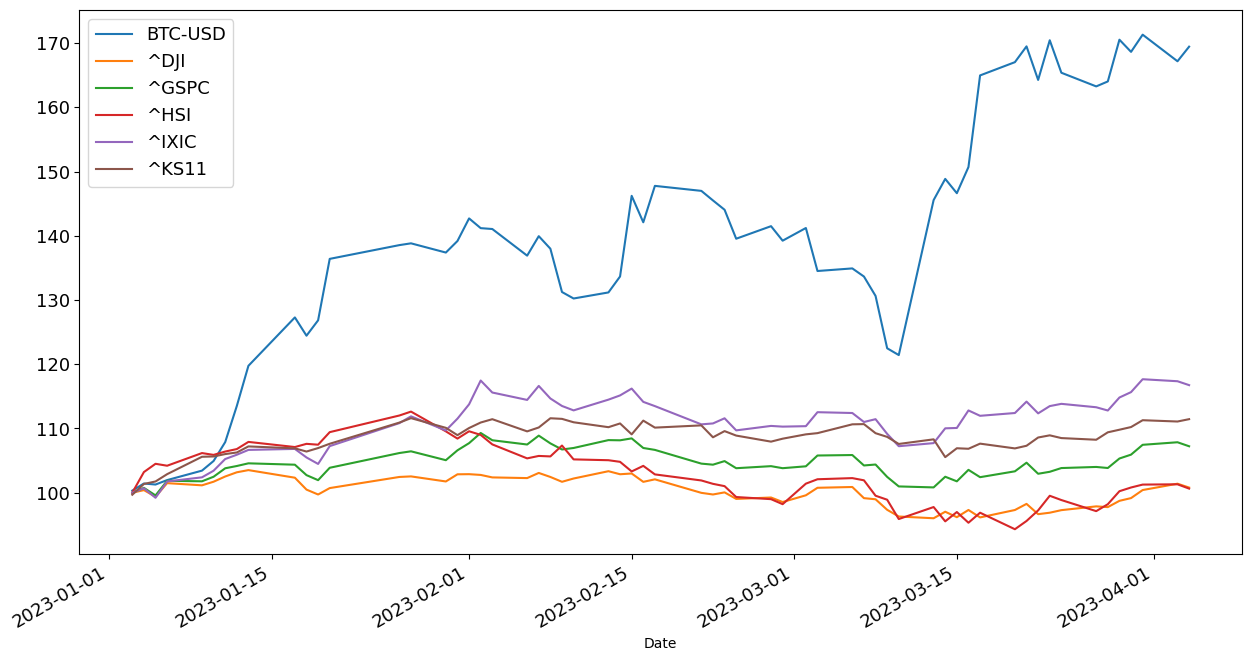

In [19]:
  
close_norm.dropna().plot(figsize = (15, 8), fontsize = 13, logy = False)


plt.legend(dict_label, fontsize = 13)
plt.show()

In [20]:
adjdf

,symbol,adj,Volume,price_ch
0,BTCUSDT,0.394272,1.869124e+09,0.000134
1,ETHUSDT,0.496917,9.675937e+08,0.021007
2,BNBUSDT,0.437301,1.005970e+08,0.011583
3,NEOUSDT,0.726361,5.653356e+06,-0.008319
4,LTCUSDT,0.571495,6.345663e+07,-0.003132
...,...,...,...,...
381,IDUSDT,1.312253,5.227817e+07,-0.002932
382,ARBUSDT,0.901483,2.709179e+08,0.011422
383,LOOMUSDT,0.434718,4.011498e+05,0.014592
384,OAXUSDT,1.163885,9.417585e+06,0.007373
